In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initial Admin Inputs

In [2]:
# initial Admin inputs from front-end
# GPU processing required, by default

# model data source - pick one: 1) title, 2) article
# title is about 4x faster, but less accurate
text_source = 'title' # title by default

# number of articles (records) to model with
num_articles = 12000 # default value is 10,000, max for our datasets is 15,000 for now

# maximum batch size, adjusts depending on num_articles
if num_articles <10001:
  max_batch_size = 16
elif num_articles <20001:
  max_batch_size = 8
elif num_articles <40001:
  max_batch_size = 4
else:
  max_batch_size = 1

# Initial Data Load and Processing

In [3]:
import pandas as pd
import numpy as np

In [4]:
# latin1 encoded, randomize rows

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/news2.7m-gensim-titles.csv', encoding="latin1", nrows=250000)
df = df.fillna(method="ffill")
df = df.sample(frac=1)

In [5]:
df.head()

,id,title_clean,num_words_title
113210,2530980,turkey unveils first fully homemade car in bil...,11
36640,572481,preview twins at yankees,4
42601,693021,target actelion could exit swiss benchmark smi...,10
183880,52212,euro zone bank profitability to dip this year ...,10
143127,4799,bachelorette star colton underwood admits virg...,10


In [6]:
import re

def labeling(x):

  label_health = ['heal', 'health', 'healthy', 'medicine', 'doctor', 'heart', 'exercise', 'coronavirus', 'flu', 'pandemic', 'organ', 'disease',
                  'obamacare', 'vape', 'novartis', 'vaping', 'cigarettes', 'cigarette', 'lung', 'smoke', 'juul', 'smoking', 'pfizer', 'tobacco',
                  'marijuana', 'opioid', 'pharm', 'cancer', 'merck', 'pharma', 'heroin', 'cannabis', 'cdc', 'pharmaceutical', 'asthma', 'gilead',
                  'hiv', 'bayer', 'bacteria', 'weighs', 'implants', 'obesity', 'workout', 'fitness', 'pregnant', 'breast', 'diet', 'aetna', 'medicare',
                  'medicaid', 'fda', 'immunotherapy', 'drug', 'drugs', 'pill', 'medical', 'oncology', 'autism', 'depression', 'ebola', 'suicide', 'genetic',
                  'hepatitis', 'vaccines', 'migraine', 'clinical', 'mylan', 'screening', 'trials', 'teva', 'overdose', 'transplant', 'cure', 'medicines',
                  'measles', 'addiction', 'hospital', 'hospitals', 'pharmaceutical', 'epipen', 'medicines', 'pot', 'chronic', 'fatal', 'antibiotic', 'deadly', 'therapeutics',
                  'therapies', 'injection', 'dementia', 'patient', 'patients', 'hospitalized', 'dr', 'opioids', 'healthcare', 'nursing', 'clinical', 'elderly', 'illness',
                  'diagnosed', 'treatments', 'treatment', 'adhd', 'mental', 'sick', 'sex', 'sexual', 'teen', 'babies', 'urges', 'disorder', 'baby', 'syndrome', 'stress', 
                  'quarantine', 'listeria', 'meat', 'eating', 'foods', 'diabetes', 'fiber', 'cholesterol', 'beef', 'salmonella', 'sugar', 'liver', 'flavored', 'swine',
                  'outbreak', 'outbreaks', 'coli', 'babies', 'measles', 'vaccination', 'polio', 'microcephaly', 'malaria', 'mosquitoes', 'immunotherapy', ]

  label_tech = ['tech', 'technology', 'comput', 'robot', 'robots', 'machine', 'crypto', 'internet', 'hacker', 'hacking', 'ransomware', 'cybersecurity', 
                'malware', 'encryption', 'cyber', 'security', 'bitcoin', 'baidu', 'blockchain', 'microsoft', 'comcast', 'amazon', 'uber', 'lyft', 'driverless',
                'zuckerberg', 'oculus', 'elon', 'musk', 'broadcom', 'drone', 'hyperloop', 'tinder', 'whatsapp', 'tencent', 'spacex', 'airbnb', 'vr', 'quantum',
                'bezos', 'alibaba', 'qualcomm', 'tesla', 'ebay', 'netflix', 'youtube', 'instagram', 'google', 'twitter', 'tweets', 'solar', 'amd', 'autonomous',
                'samsung', 'mars', 'biotech', 'valuation', 'spotify', 'reddit', 'yahoo', 'ai', 'siri', 'foxconn', 'machines', 'babbage', 'biotechnology', 'engineer',
                'augmented', 'ibm', 'smartwatch', 'smartphone', 'smartphones', 'earbuds', 'lenovo', 'huawei', 'xiaomi', 'oracle', 'nsa', 'snapchat', 'ios', 'apple',
                'android', 'siri', 'macbook', 'ericsson', 'lg', 'sony', 'nintendo', 'gopro', 'apps', 'mobile', 'dengue', 'infections', 'cholera', 'salesforce',
                'galaxy', 'nokia', 'verizon', 'toshiba', 'iphones', 'vodafone', 'dell', 'tablet', 'ipad', 'airpods', 'mobile', 'sprint', 'fitbit', 'intel', 'fcc', 
                'startups', 'startup', 'videos', 'video', 'neutrality', 'website', 'websites', 'hits', 'podcast', 'linkedin', 'antitrust', 'patents', 'telecoms', 
                'developers', 'unveils', 'launches', 'launching', 'technologies', ] 

  label = ''
  if re.search(r'\b(?:{})\b'.format('|'.join(label_health)), x.title_clean):
    label = 1
  elif re.search(r'\b(?:{})\b'.format('|'.join(label_tech)), x.title_clean):
    label = 2
  else:
    label = 0
  return label

In [7]:
# df['label'] = df.title_clean.str.contains(r'\b(?:{})\b'.format('|'.join(label_health)))
df['label'] = df.apply(labeling, axis=1)

In [8]:
df['label'].value_counts()
#df.loc[df['label']==True]

0    201234
2     24928
1     23838
Name: label, dtype: int64

In [9]:
# health = df[df['label'].str.contains('health')]
# tech = df[df['label'].str.contains('tech')]
# other = df[df['label'].str.contains('other')]

health = df[df['label'].isin([1])]
tech = df[df['label'].isin([2])]
other = df[df['label'].isin([0])]

health.shape, tech.shape, other.shape

((23838, 4), (24928, 4), (201234, 4))

In [10]:
health = health.sample(frac=1)
tech = tech.sample(frac=1)
other = other.sample(frac=1)

health = health[0:15000]
tech = tech[0:15000]
other = other[0:30000]

In [11]:
# combined

df = pd.concat([health, tech, other])
df = df.sample(frac=1)
print(df.shape)
df.head()

(60000, 4)


,id,title_clean,num_words_title,label
236203,112970,spacex valuation is expected to climb to billion,8,2
35002,529307,prime opportunities investment says iwg reject...,8,0
51495,886065,epa likely to grant partial waivers from biofu...,11,0
230259,105991,elizabeth warren brutal call to action against...,9,0
157599,21650,celebrity goat yoga namasteeeeeh,4,0


**Splitting into Training vs Test datasets**

In [12]:
# randomize rows to prep for dataset split

df = df.sample(frac=1)
df

,id,title_clean,num_words_title,label
203111,74522,corrected update bill cosby appeals conviction...,10,1
48837,828569,former executive of duo security zscaler joins...,11,2
151595,14695,maybe republican voters don hate universal hea...,10,1
185771,54391,inside downing street,3,0
104375,2428596,apple watch detects irregular heartbeats in study,7,2
...,...,...,...,...
19338,188918,rise of smaller rivals throws up fresh challen...,10,2
172114,38487,apple is suing over fake chargers sold by amazon,9,2
33869,508428,plane carrying madeira bus crash survivors lan...,9,0
191476,61015,why does hollywood keep making the same movies...,12,0


In [13]:
# create initial train and test sets, 70/30 split

training_set = df.sample(frac=0.7) # training set
test_set = df.drop(training_set.index) # test set

training_set.shape, test_set.shape

((42000, 4), (18000, 4))

# Saved Train and Test Data Sets

In [14]:
# keeping here for reference

# saved training_set
path_training_set = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_training_set.csv'

with open(path_training_set, 'w', encoding = 'latin1') as f:
  training_set.to_csv(f)

# saved test_set
path_test_set = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_test_set.csv'

with open(path_test_set, 'w', encoding = 'latin1') as f:
  test_set.to_csv(f)

**Smaller Sets - Reference**

In [15]:
# block for saving smaller datasets

path_training_mini = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_training_set_mini.csv'

training_set.to_csv(path_training_mini, encoding='latin1', header='True', index='False')


path_test_mini = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_test_set_mini.csv'

test_set.to_csv(path_test_mini, encoding='latin1', header='True', index='False')

# sanity check
training_set.shape, test_set.shape

((42000, 4), (18000, 4))

**Smaller Set - determined by admin input**

In [16]:
# block for saving smaller datasets

import math

training_upper = math.floor(num_articles * 0.7)
test_upper = num_articles - training_upper

path_training_mini = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_training_set_mini.csv'

training_mini = training_set[0:training_upper]
training_mini.to_csv(path_training_mini, encoding='latin1', header='True', index='False')


path_test_mini = '/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_test_set_mini.csv'

test_mini = test_set[0:test_upper]
test_mini.to_csv(path_test_mini, encoding='latin1', header='True', index='False')

training_mini.shape, test_mini.shape

((8400, 4), (3600, 4))

**Reloading Saved Mini Sets**

In [17]:
# Reloading mini data sets for use in model
import numpy as np
import pandas as pd

# training_set_mini
training_mini = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_training_set_mini.csv', encoding="latin1")

# test_set_mini
test_mini = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FourthBrain ML Engineer/4B_GLG/Datasets/NER_data_mini/0_combined_test_set_mini.csv', encoding="latin1")

In [18]:
# sanity check
training_mini.shape, test_mini.shape

((8400, 5), (3600, 5))

# Model using XLNet

In [19]:
# NOTE: this may require restarting the runtime and running everything again a couple of times

# Installing and importing dependencies
!pip install torch
!pip install transformers

#Installing libraries 
import torch
import transformers
from transformers import XLNetTokenizer, XLNetModel, XLNetForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report #, accuracy
from textwrap import wrap
from pylab import rcParams
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
import torch.nn.functional as tFn


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm, trange
import io
import matplotlib.pyplot as plt
% matplotlib inline

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
# SentencePiece is a prereq for XLNetTokenizer
!pip install sentencepiece

In [22]:
# reference from http://mccormickml.com/2019/09/19/XLNet-fine-tuning/

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

# XLNet Model

In [24]:
df_training = training_mini

In [25]:
# create sentence and label lists
# using selection by admin: title or article
if text_source == 'title':
  sentences = df_training.title_clean.values
else:
  sentences = df_training.article_clean.values

In [26]:
sentences = [sentence + " [SEP] [CLS] " for sentence in sentences]
labels = df_training.label.values

In [27]:
# NOTE: may need to restart the runtime once or twice to get this cell block to work

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁momentum', '▁builds', '▁in', '▁for', '▁disclaimer', 's', '▁on', '▁internet', '▁election', '▁ads', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [28]:
# XLNet requires input sentences to be of the same length
# this is managed via use of truncate and pad

# Set the maximum sequence length. 
# title -- using 128 to account for longer titles (up to ~15 words)
# article -- using 384 to take into account first ~50 words in an article 
if text_source == 'title':
  MAX_LEN = 128
else:
  # MAX_LEN = 384
  MAX_LEN = 256

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [29]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [30]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [31]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [32]:
# Select a batch size for training. 
# For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128.
# Using 16 to avoid memory issues.
# batch_size = 16
batch_size = max_batch_size

# Create an iterator of our data with torch DataLoader. This helps save on memory during training.
# Unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [33]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=3)
model.cuda()

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [34]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [35]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [36]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.5645442582588032


Epoch:  33%|███▎      | 1/3 [03:49<07:38, 229.35s/it]

Validation Accuracy: 0.9166666666666666
Train loss: 0.21008999577955043


Epoch:  67%|██████▋   | 2/3 [07:45<03:53, 233.55s/it]

Validation Accuracy: 0.944047619047619
Train loss: 0.09822361340164823


Epoch: 100%|██████████| 3/3 [11:42<00:00, 234.06s/it]

Validation Accuracy: 0.9595238095238096


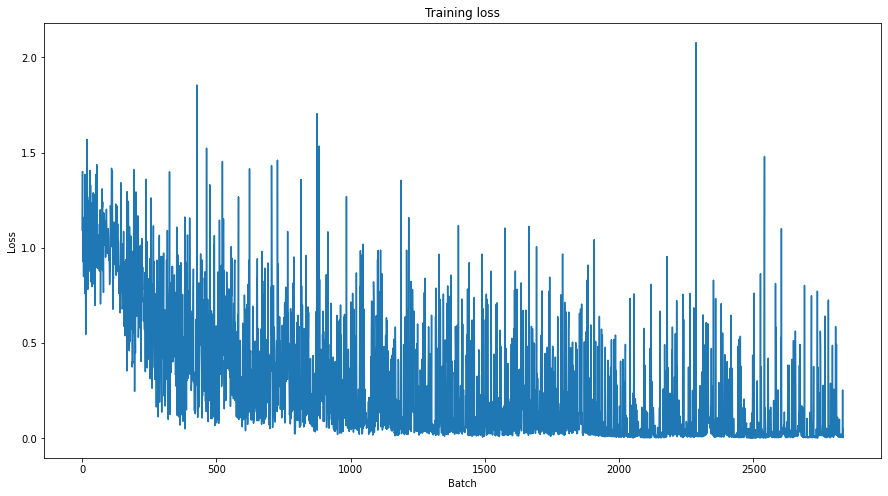

In [38]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [39]:
df_test = test_mini

In [40]:
# Predict and Evaluate on Holdout Set

# Create sentence and label lists
# using selection by admin: title or article
if text_source == 'title':
  sentences = df_test.title_clean.values
else:
  sentences = df_test.article_clean.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]
labels = df_test.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = MAX_LEN
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = max_batch_size  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [41]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [42]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [43]:
matthews_set

[1.0,
 1.0,
 1.0,
 1.0,
 0.806801581908253,
 1.0,
 1.0,
 1.0,
 0.6813851438692469,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6668859288553503,
 -0.14285714285714285,
 0.6813851438692469,
 1.0,
 0.7453559924999299,
 1.0,
 1.0,
 0.806801581908253,
 0.5789473684210527,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6546536707079772,
 1.0,
 1.0,
 0.7745966692414834,
 1.0,
 1.0,
 1.0,
 0.806801581908253,
 1.0,
 1.0,
 1.0,
 0.8295150620062532,
 1.0,
 1.0,
 0.8260331876309022,
 1.0,
 0.6546536707079772,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7735737130957593,
 1.0,
 0.7701540462154054,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8134892168199607,
 1.0,
 1.0,
 1.0,
 0.8295150620062532,
 1.0,
 0.7735737130957593,
 1.0,
 1.0,
 0.8029550685469661,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.806801581908253,
 1.0,
 1.0,
 0.7701540462154054,
 1.0,
 0.6668859288553503,
 0.8157894736842105,
 0.806801581908253,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8295150620062532,
 1.0,
 1.0,
 1.0,
 0.8068015819

In [44]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [45]:
# reference for matthews_corrcoef -- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

matthews_corrcoef(flat_true_labels, flat_predictions)


0.9426133296341841

# Save Model

In [46]:
# torch.save(model, 'blah2.pkl')
torch.save(model.state_dict(), 'blah3.pkl')
torch.save(model.state_dict(), 'blah3.pt')
torch.save(model.state_dict(), 'blah3.pth')